In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import svm
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, KFold, train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import RFE, RFECV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [4]:
# Read data from the csv file
df_raw = pd.read_csv('./data/survey_results_public.csv', sep=',')
df_raw

,ResponseId,MainBranch,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,LearnCodeCoursesCert,YearsCode,...,TimeSearching,TimeAnswering,Onboarding,ProfessionalTech,TrueFalse_1,TrueFalse_2,TrueFalse_3,SurveyLength,SurveyEase,ConvertedCompYearly
0,1,None of these,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I am a developer by profession,"Employed, full-time",Fully remote,Hobby;Contribute to open-source projects,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Too long,Difficult,NaN
2,3,"I am not primarily a developer, but I write co...","Employed, full-time","Hybrid (some remote, some in-person)",Hobby,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Books / Physical media;Friend or family member...,Technical documentation;Blogs;Programming Game...,NaN,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Neither easy nor difficult,40205.0
3,4,I am a developer by profession,"Employed, full-time",Fully remote,I don’t code outside of work,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Books / Physical media;School (i.e., Universit...",NaN,NaN,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Easy,215232.0
4,5,I am a developer by profession,"Employed, full-time","Hybrid (some remote, some in-person)",Hobby,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Other online resources (e.g., videos, blogs, f...",Technical documentation;Blogs;Stack Overflow;O...,NaN,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Too long,Easy,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73263,73264,I am a developer by profession,"Employed, full-time",Fully remote,Freelance/contract work,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Other online resources ...,Technical documentation;Blogs;Written Tutorial...,Udemy,8,...,30-60 minutes a day,Less than 15 minutes a day,Just right,DevOps function;Microservices;Developer portal...,Yes,Yes,Yes,Too long,Easy,NaN
73264,73265,I am a developer by profession,"Employed, full-time",Full in-person,Hobby,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)","Other online resources (e.g., videos, blogs, f...",Technical documentation;Blogs;Written Tutorial...,Coursera;Udemy;Udacity,6,...,15-30 minutes a day,60-120 minutes a day,Very long,None of these,No,Yes,Yes,Too long,Easy,NaN
73265,73266,"I am not primarily a developer, but I write co...","Employed, full-time","Hybrid (some remote, some in-person)",Hobby;School or academic work,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Other online resources ...,Technical documentation;Programming Games;Stac...,Udemy;Codecademy;Pluralsight;edX,42,...,30-60 minutes a day,60-120 minutes a day,Just right,None of these,No,No,No,Appropriate in length,Easy,NaN
73266,73267,I am a developer by profession,"Employed, full-time","Hybrid (some remote, some in-person)",Hobby,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;On the job training,NaN,NaN,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Easy,NaN


# Data analysis

### Data cleaning

For analysing the salary, only use the entries from people that are professional developers.

Data that will probably have an influence on the salary:
- EdLevel
- YearsCode
- YearsCodePro
- OrgSize
- Age

Data that might be interesting to analyse if it has an effect on the salary:
- Employment: should be quite clear, but could be still interesting (although most are probably not professionals then)
- RemoteWork: very interesting, if that has an effect on the salary, but we have to be very careful
- DevType: would be very interesting to see how the differences are between different developer fields
- Country: how much are the differences in the countries? could be very interesting
- LanguageHaveWorkedWith: are there specific languages with that people have a higher salary?
- Gender: are there still differences in men/women/others?
- Ethnicity: are there differences in ethnicities within one country?

What is already analysed by other people?
- Salary by language 2021 vs 2022 (https://www.kaggle.com/code/edgarp95/ranking-stackoverflow-2021-vs-2022)
- Salary by country, by experience, by education level, by number of languages known (https://www.kaggle.com/code/do1likethis/which-devs-get-paid-more-and-why) -> we have to watch out that we differ in this analysis by a guy on kaggle, as it is quite similar to what we are doing
- Gender pay gap (https://www.kaggle.com/code/dima806/genderpaygap-stackoverflowdevelopersurvey2022)
- Salary by country, by dev type, by dev type and country (https://www.kaggle.com/code/ahmetkayapnar/exp-data-analysis-stackoverflow-developers-2022)
- "Key factors for developer salaries in 2022" (https://medium.com/mlearning-ai/key-factors-for-developer-salaries-in-2022-lessons-from-the-stack-overflow-survey-ec5bb99f3f79)

What I think we should analyse:
- The main leading question would be "How is the salary of a developer affected and what makes a high salary?".
- We should start with cleaning up the data (improving the content, but also filtering out faulty datasets (NaN's, impossible salary, etc.).
- For analysing the salary I think we should start with the most obviously like EdLevel, YearsCodePro, OrgSize and Age. Just a small plot to see what the effects are, to then go deeper into it. Those will most likely already be analysed by a dozen other people, but it is necessary that we not leave it out.
- Then go into 1 or 2 interesting questions that were not directly done before. (f.e. country together with gender/ethnicity)
- Alternatively we cna also then make a specific hypothesis like "high salary developers are dominated by man" and then go deeper into that. And then also do a hypothesis test on it.
- After that analysis a Linear Regression (or similar prediction) would be good (maybe only for data of the USA or Germany) and then get the coefficients.



Allgemeine research question mit datenaufbereitung, datenanalyse und logistische Regression
danach hypothesen test auf ein spezielles attribut

In [5]:
# select only those columns that are important for this analysis
df = df_raw.copy()
df = df[['ConvertedCompYearly', 'EdLevel', 'YearsCode', 'YearsCodePro', 'OrgSize', 'Age', 'MainBranch', 'RemoteWork', 'DevType', 'Country', 'LanguageHaveWorkedWith', 'Gender', 'Ethnicity']]

# rename columns
df = df.rename(columns={
    'ConvertedCompYearly':'Salary',
    'MainBranch':'Employment',
    'LanguageHaveWorkedWith':'ProgLanguage'
})

# Replace unnecessarily long entries with shorter ones
df['Employment'] = df['Employment'].replace(
    to_replace=[
        "I am a developer by profession",
        "I am a student who is learning to code",
        "I am not primarily a developer, but I write code sometimes as part of my work",
        "I code primarily as a hobby",
        "I used to be a developer by profession, but no longer am",
        "None of these"
    ],
    value=[
        "profession",
        "student",
        "part of work",
        "hobby",
        "ex profession",
        "unknown"
    ]
)

df['EdLevel'] = df['EdLevel'].replace(
    to_replace=[
        "Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)",
        "Bachelor’s degree (B.A., B.S., B.Eng., etc.)",
        "Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",
        "Other doctoral degree (Ph.D., Ed.D., etc.)",
        "Some college/university study without earning a degree",
        "Something else",
        "Professional degree (JD, MD, etc.)",
        "Primary/elementary school",
        "Associate degree (A.A., A.S., etc.)"
    ],
    value=[
        "Secondary school",
        "Bachelor’s degree",
        "Master’s degree",
        "Doctoral degree",
        "University courses",
        "Unknown",
        "Professional degree",
        "Primary school",
        "Associate degree"
    ]
)

df['YearsCode'] = df['YearsCode'].replace(
    to_replace=[
        "More than 50 years",
        "Less than 1 year"
    ],
    value=[
        "50",
        "0",
    ]
)

df['YearsCodePro'] = df['YearsCodePro'].replace(
    to_replace=[
        "More than 50 years",
        "Less than 1 year"
    ],
    value=[
        "50",
        "0",
    ]
)

df['OrgSize'] = df['OrgSize'].replace(
    to_replace=[
        "Just me - I am a freelancer, sole proprietor, etc.",
        "2 to 9 employees",
        "10 to 19 employees",
        "20 to 99 employees",
        "100 to 499 employees",
        "500 to 999 employees",
        "1,000 to 4,999 employees",
        "5,000 to 9,999 employees",
        "10,000 or more employees",
        "I don’t know"
    ],
    value=[
        "1",
        "2 to 9",
        "10 to 19",
        "20 to 99",
        "100 to 499","500 to 999",
        "1,000 to 4,999",
        "5,000 to 9,999",
        "10,000 or more",
        "unknown"
    ]
)

df['RemoteWork'] = df['RemoteWork'].replace(
    to_replace=[
        "Full in-person",
        "Hybrid (some remote, some in-person)",
        "Fully remote"
    ],
    value=[
        "in-person",
        "hybrid",
        "remote"
    ]
)

df['Age'] = df['Age'].replace(
    to_replace=[
        "Under 18 years old",
        "18-24 years old",
        "25-34 years old",
        "35-44 years old",
        "45-54 years old",
        "55-64 years old",
        "65 years or older",
        "Prefer not to say"
    ],
    value=[
        "under 18",
        "18-24",
        "25-34",
        "35-44",
        "45-54",
        "55-64",
        "over 65",
        "unknown"
    ]
)

# Convert columns into numeric values
df['YearsCode'] = pd.to_numeric(df['YearsCode'], errors='coerce')
df['YearsCodePro'] = pd.to_numeric(df['YearsCodePro'], errors='coerce')

# delete all NaN in Salary as those entries cant be used
broken_ds = df[df['Salary'].isnull() == True]
df = df.drop(broken_ds.index, axis=0)

df

,Salary,EdLevel,YearsCode,YearsCodePro,OrgSize,Age,Employment,RemoteWork,DevType,Country,ProgLanguage,Gender,Ethnicity
2,40205.0,Master’s degree,14.0,5.0,20 to 99,25-34,part of work,hybrid,Data scientist or machine learning specialist;...,United Kingdom of Great Britain and Northern I...,C#;C++;HTML/CSS;JavaScript;Python,Man,White
3,215232.0,Bachelor’s degree,20.0,17.0,100 to 499,35-44,profession,remote,"Developer, full-stack",Israel,C#;JavaScript;SQL;TypeScript,Man,White
8,49056.0,Master’s degree,6.0,6.0,unknown,25-34,profession,hybrid,"Developer, back-end",Netherlands,NaN,Woman,European
10,60307.0,Bachelor’s degree,5.0,2.0,100 to 499,18-24,profession,hybrid,"Developer, full-stack;Developer, back-end",United Kingdom of Great Britain and Northern I...,Bash/Shell;C#;HTML/CSS;JavaScript;PowerShell;SQL,Man,European
11,194400.0,Bachelor’s degree,12.0,10.0,20 to 99,35-44,part of work,remote,Engineering manager,United States of America,C#;HTML/CSS;JavaScript;PowerShell;Python;Rust;SQL,Man,White
...,...,...,...,...,...,...,...,...,...,...,...,...,...
73116,115000.0,Bachelor’s degree,21.0,16.0,10 to 19,35-44,profession,hybrid,"Developer, front-end;Developer, full-stack;Dev...",United States of America,C#;HTML/CSS;Java;JavaScript,Man,White
73118,57720.0,Bachelor’s degree,4.0,3.0,20 to 99,25-34,profession,remote,"Developer, full-stack;Developer, mobile",Nigeria,HTML/CSS;JavaScript;TypeScript,Man,Black
73119,70000.0,Bachelor’s degree,5.0,1.0,"5,000 to 9,999",25-34,profession,hybrid,"Developer, full-stack;Data or business analyst",United States of America,C#;HTML/CSS;JavaScript;SQL;TypeScript,Man,White
73120,35192.0,Bachelor’s degree,6.0,2.0,"10,000 or more",NaN,profession,remote,"Developer, back-end;DevOps specialist",Spain,Groovy;Haskell;Java;JavaScript;Kotlin;Python;R...,NaN,NaN


                Salary  YearsCode  YearsCodePro
Salary        1.000000   0.047171      0.049334
YearsCode     0.047171   1.000000      0.912413
YearsCodePro  0.049334   0.912413      1.000000


<AxesSubplot: >

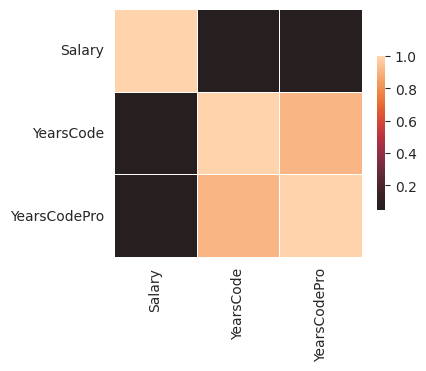

In [6]:
corr = df[['Salary', 'YearsCode', 'YearsCodePro']].corr()
print(corr)
_, heatmap_ax = plt.subplots(figsize=(4, 4))
sns.heatmap(corr, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=heatmap_ax)

_Jonas_:
There is, as expected, a high correlation between the total years coded and years coded in the profession, so for the prediction of the salary we should only choose one. Additionally, it can be seen, that to the salary there is almost no correlation, so it seems like that the experience of coding in years has almost no effect on the salary.

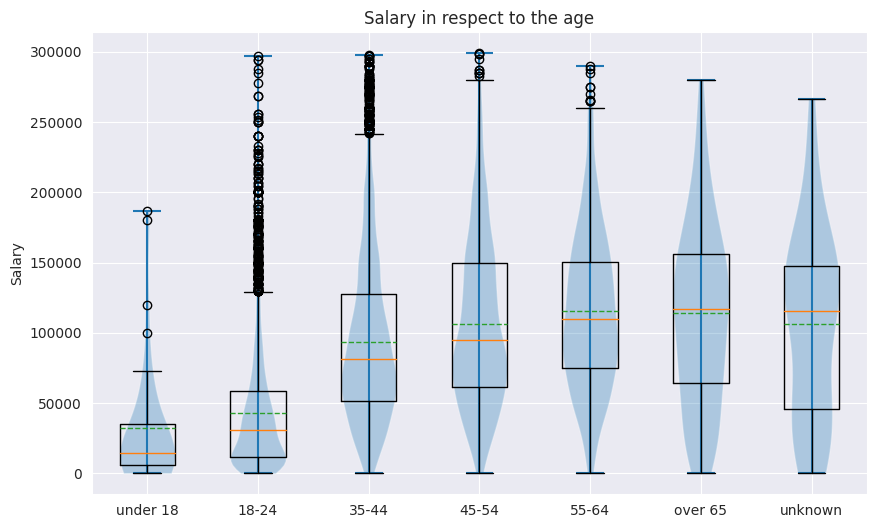

In [7]:
df_age = df.copy()
df_age = df_age[df['Salary']<300000]

data = [
    df_age[df_age['Age'] == "under 18"]['Salary'],
    df_age[df_age['Age'] == "18-24"]['Salary'],
    df_age[df_age['Age'] == "35-44"]['Salary'],
    df_age[df_age['Age'] == "45-54"]['Salary'],
    df_age[df_age['Age'] == "55-64"]['Salary'],
    df_age[df_age['Age'] == "over 65"]['Salary'],
    df_age[df_age['Age'] == "unknown"]['Salary']
]
labels=["under 18", "18-24", "35-44", "45-54", "55-64", "over 65", "unknown"]

_, ax = plt.subplots(figsize=(10, 6))
ax.violinplot(data)
ax.boxplot(data, showmeans=True, meanline=True)
ax.set_ylabel("Salary")
ax.set_xticklabels(labels)
ax.set(title='Salary in respect to the age')
plt.show()

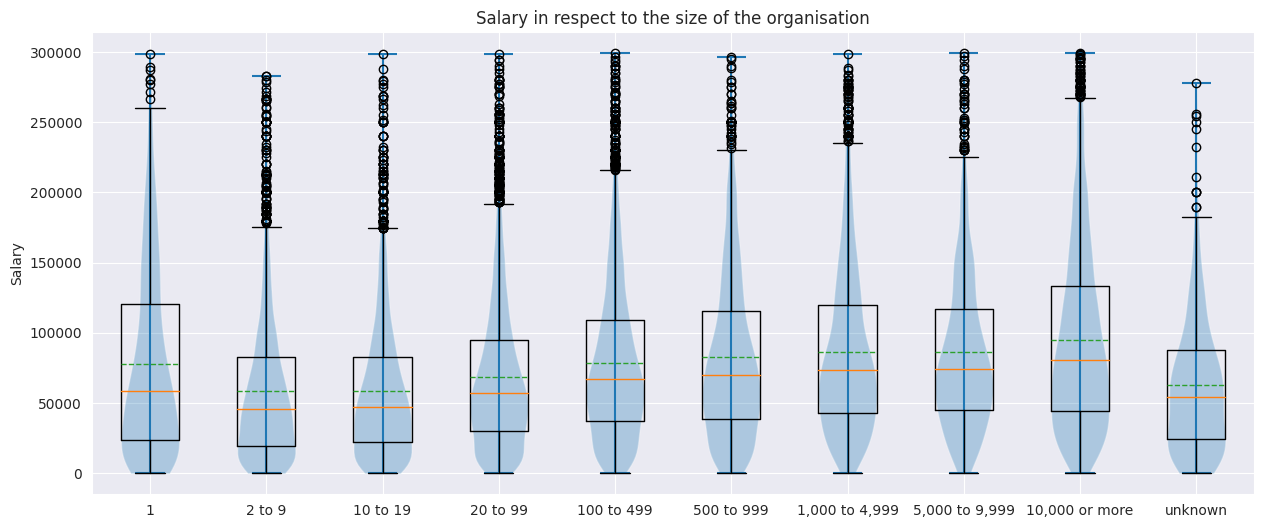

In [8]:
df_org = df.copy()
df_org = df_org[df['Salary']<300000]

data = [
    df_org[df_org['OrgSize'] == "1"]['Salary'],
    df_org[df_org['OrgSize'] == "2 to 9"]['Salary'],
    df_org[df_org['OrgSize'] == "10 to 19"]['Salary'],
    df_org[df_org['OrgSize'] == "20 to 99"]['Salary'],
    df_org[df_org['OrgSize'] == "100 to 499"]['Salary'],
    df_org[df_org['OrgSize'] == "500 to 999"]['Salary'],
    df_org[df_org['OrgSize'] == "1,000 to 4,999"]['Salary'],
    df_org[df_org['OrgSize'] == "5,000 to 9,999"]['Salary'],
    df_org[df_org['OrgSize'] == "10,000 or more"]['Salary'],
    df_org[df_org['OrgSize'] == "unknown"]['Salary']
]

labels=["1", "2 to 9", "10 to 19", "20 to 99", "100 to 499", "500 to 999", "1,000 to 4,999", "5,000 to 9,999", "10,000 or more", "unknown"]

_, ax = plt.subplots(figsize=(15, 6))
ax.violinplot(data)
ax.boxplot(data, showmeans=True, meanline=True)
ax.set_ylabel("Salary")
ax.set_xticklabels(labels)
ax.set(title='Salary in respect to the size of the organisation')
plt.show()

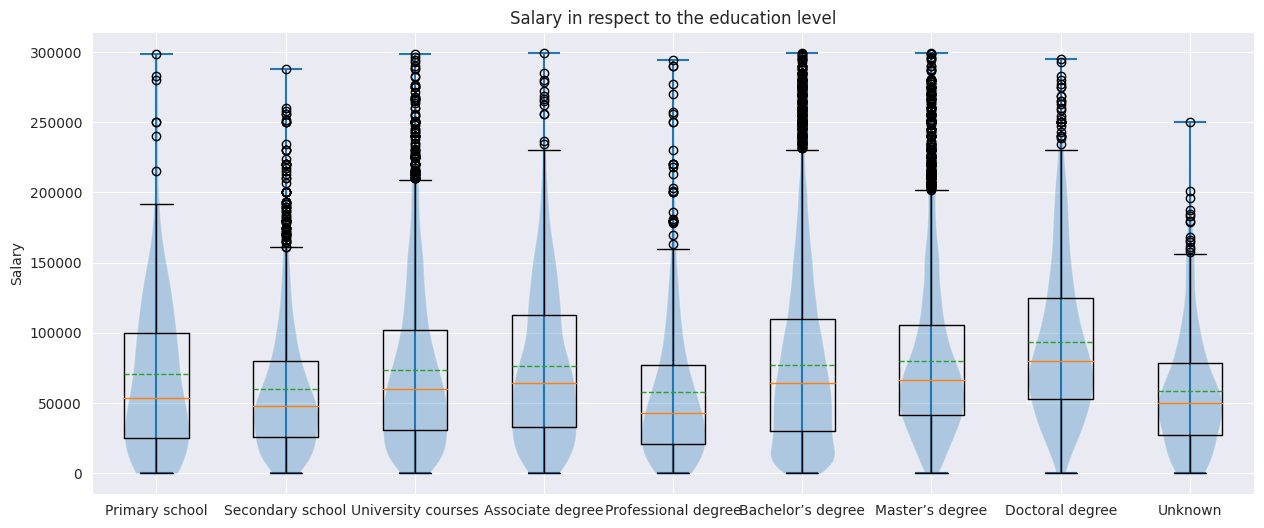

In [9]:
df_edu = df.copy()
df_edu = df_edu[df['Salary']<300000]

data = [
    df_edu[df_edu['EdLevel'] == "Primary school"]['Salary'],
    df_edu[df_edu['EdLevel'] == "Secondary school"]['Salary'],
    df_edu[df_edu['EdLevel'] == "University courses"]['Salary'],
    df_edu[df_edu['EdLevel'] == "Associate degree"]['Salary'],
    df_edu[df_edu['EdLevel'] == "Professional degree"]['Salary'],
    df_edu[df_edu['EdLevel'] == "Bachelor’s degree"]['Salary'],
    df_edu[df_edu['EdLevel'] == "Master’s degree"]['Salary'],
    df_edu[df_edu['EdLevel'] == "Doctoral degree"]['Salary'],
    df_edu[df_edu['EdLevel'] == "Unknown"]['Salary']
]

labels=["Primary school","Secondary school","University courses","Associate degree","Professional degree","Bachelor’s degree","Master’s degree","Doctoral degree","Unknown"]

_, ax = plt.subplots(figsize=(15, 6))
ax.violinplot(data)
ax.boxplot(data, showmeans=True, meanline=True)
ax.set_ylabel("Salary")
ax.set_xticklabels(labels)
ax.set(title='Salary in respect to the education level')
plt.show()

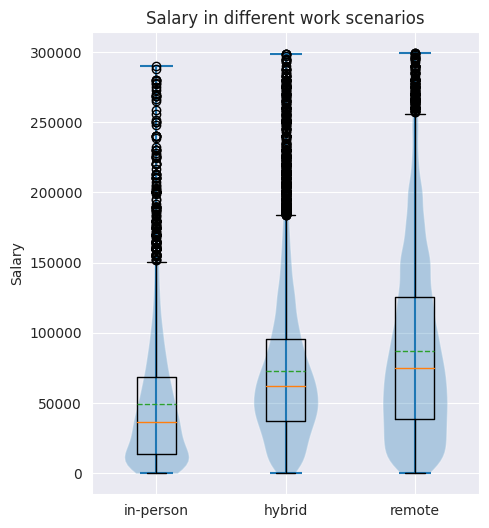

In [10]:
df_rem = df.copy()
df_rem = df_rem[df['Salary']<300000]

data = [
    df_rem[df_rem['RemoteWork'] == "in-person"]['Salary'],
    df_rem[df_rem['RemoteWork'] == "hybrid"]['Salary'],
    df_rem[df_rem['RemoteWork'] == "remote"]['Salary']
]

labels=["in-person","hybrid","remote"]

_, ax = plt.subplots(figsize=(5, 6))
ax.violinplot(data)
ax.boxplot(data, showmeans=True, meanline=True)
ax.set_ylabel("Salary")
ax.set_xticklabels(labels)
ax.set(title='Salary in different work scenarios')
plt.show()

In [44]:
df_gen = df[['Salary', 'Gender']].copy()
df_gen = df_gen.dropna()
df_gen[~df_gen['Gender'].isin(['Man', 'Woman', 'Prefer not to say'])] = "Other"

df_gen['Gender'].unique()

array(['Man', 'Woman', 'Prefer not to say', 'Other'], dtype=object)

In [84]:
df_gen = df[['Salary', 'Gender']].copy()
df_gen = df_gen.dropna()
df_gen[~df_gen['Gender'].isin(['Man', 'Woman', 'Prefer not to say'])]['Salary'] = "Other"
df_gen[~df_gen['Gender'].isin(['Man', 'Woman', 'Prefer not to say'])]



# df_gen['Salary'] = pd.to_numeric(df_gen['Salary'], errors='coerce')

# df_gen = df_gen[df_gen['Salary']<300000]
# df_gen[df_gen['Salary']>1000]['Gender'].unique()
# df_gen[df_gen['Gender'] == "Other"]

# df_gen['Gender'].unique()


# data = [
#     df_gen[df_gen['Gender'] == "Man"]['Salary'],
#     df_gen[df_gen['Gender'] == "Woman"]['Salary'],
#     df_gen[df_gen['Gender'] == "Other"]['Salary'],
#     df_gen[df_gen['Gender'] == "Prefer not to say"]['Salary']
# ]
#
# labels=["Man", "Woman", "Other", "Prefer not to say"]
#
# _, ax = plt.subplots(figsize=(4, 6))
# ax.violinplot(data)
# ax.boxplot(data, showmeans=True, meanline=True)
# ax.set_ylabel("Salary")
# ax.set_xticklabels(labels)
# ax.set(title='Salary in respect to different gender')
# plt.show()

/tmp/ipykernel_16380/1597692863.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gen[~df_gen['Gender'].isin(['Man', 'Woman', 'Prefer not to say'])]['Salary'] = "Other"


,Salary,Gender
379,153564.0,"Man;Non-binary, genderqueer, or gender non-con..."
404,76000.0,"Non-binary, genderqueer, or gender non-conforming"
441,350000.0,"Non-binary, genderqueer, or gender non-conforming"
485,24420.0,"Or, in your own words:"
581,47990.0,"Non-binary, genderqueer, or gender non-conforming"
...,...,...
72826,1059048.0,"Non-binary, genderqueer, or gender non-conforming"
72903,105000.0,"Woman;Non-binary, genderqueer, or gender non-c..."
72964,77850.0,"Man;Non-binary, genderqueer, or gender non-con..."
73069,113075.0,"Woman;Non-binary, genderqueer, or gender non-c..."


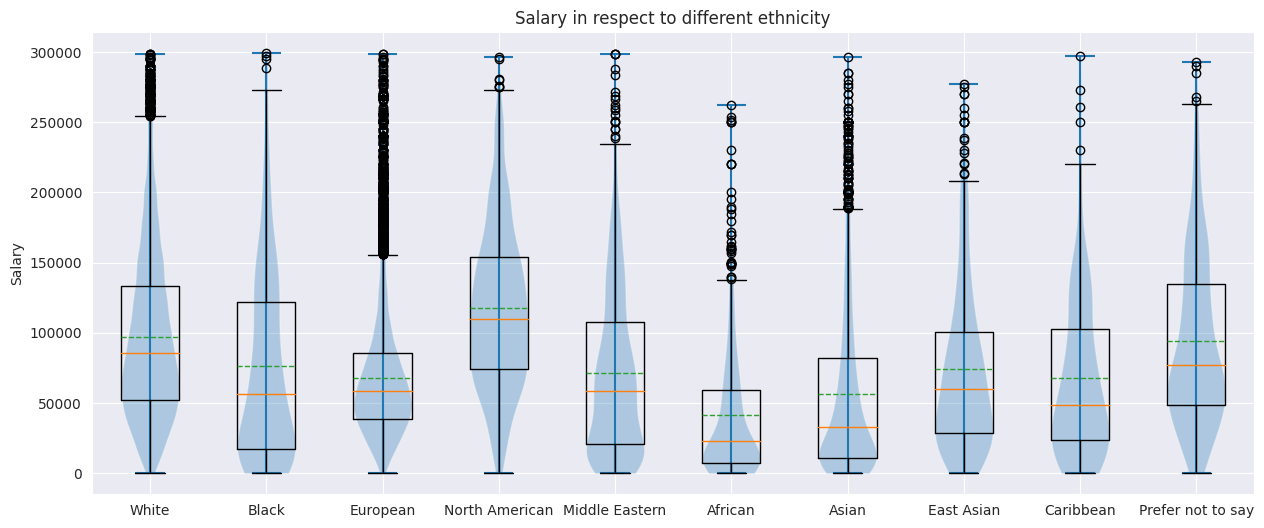

In [13]:
#### NOT ALL INCLUDED!!

df_eth = df.copy()
df_eth = df_eth[df['Salary']<300000]
df_eth['Ethnicity'] = df_eth['Ethnicity'].str.split(';')
df_eth = df_eth.explode('Ethnicity')

data = [
    df_eth[df_eth['Ethnicity'] == "White"]['Salary'],
    df_eth[df_eth['Ethnicity'] == "Black"]['Salary'],
    df_eth[df_eth['Ethnicity'] == "European"]['Salary'],
    df_eth[df_eth['Ethnicity'] == "North American"]['Salary'],
    df_eth[df_eth['Ethnicity'] == "Middle Eastern"]['Salary'],
    df_eth[df_eth['Ethnicity'] == "African"]['Salary'],
    df_eth[df_eth['Ethnicity'] == "Asian"]['Salary'],
    df_eth[df_eth['Ethnicity'] == "East Asian"]['Salary'],
    df_eth[df_eth['Ethnicity'] == "Caribbean"]['Salary'],
    df_eth[df_eth['Ethnicity'] == "Prefer not to say"]['Salary']
]

labels=["White", "Black", "European", "North American", "Middle Eastern", "African", "Asian", "East Asian", "Caribbean", "Prefer not to say"]

_, ax = plt.subplots(figsize=(15, 6))
ax.violinplot(data)
ax.boxplot(data, showmeans=True, meanline=True)
ax.set_ylabel("Salary")
ax.set_xticklabels(labels)
ax.set(title='Salary in respect to different ethnicity')
plt.show()

In [14]:
df_eth['Ethnicity'].unique()

array(['White', 'European', 'North American', 'Prefer not to say',
       'Middle Eastern', 'African', 'Asian', 'East Asian', 'Black',
       'Caribbean', 'Southeast Asian', 'Hispanic or Latino/a', nan,
       'Or, in your own words:', 'South American', 'Indian',
       'South Asian', "I don't know", 'North African', 'Multiracial',
       'Ethnoreligious group',
       'Indigenous (such as Native American or Indigenous Australian)',
       'Biracial', 'Central American', 'Central Asian',
       'Pacific Islander'], dtype=object)

In [15]:
#### TOO MANY INDIVIDUAL PROGRAMMING LANGUAGES TO LOOK AT ALL!!

df_prog = df.copy()
df_prog = df_prog[df['Salary']<300000]
df_prog['ProgLanguage'] = df_prog['ProgLanguage'].str.split(';')
df_prog = df_prog.explode('ProgLanguage')

df_prog['ProgLanguage'].unique()

# data = [
#     df_prog[df_prog['ProgLanguage'] == "White"]['Salary'],
#     df_prog[df_prog['ProgLanguage'] == "Black"]['Salary'],
#     df_prog[df_prog['ProgLanguage'] == "European"]['Salary'],
#     df_prog[df_prog['ProgLanguage'] == "North American"]['Salary'],
#     df_prog[df_prog['ProgLanguage'] == "Middle Eastern"]['Salary'],
#     df_prog[df_prog['ProgLanguage'] == "African"]['Salary'],
#     df_prog[df_prog['ProgLanguage'] == "Asian"]['Salary'],
#     df_prog[df_prog['ProgLanguage'] == "East Asian"]['Salary'],
#     df_prog[df_prog['ProgLanguage'] == "Caribbean"]['Salary'],
#     df_prog[df_prog['ProgLanguage'] == "Prefer not to say"]['Salary']
# ]
#
# labels=["White", "Black", "European", "North American", "Middle Eastern", "African", "Asian", "East Asian", "Caribbean", "Prefer not to say"]
#
# _, ax = plt.subplots(figsize=(15, 6))
# ax.violinplot(data)
# ax.boxplot(data, showmeans=True, meanline=True)
# ax.set_ylabel("Salary")
# ax.set_xticklabels(labels)
# ax.set(title='Salary in respect to different programming languages')
# plt.show()

array(['C#', 'C++', 'HTML/CSS', 'JavaScript', 'Python', 'SQL',
       'TypeScript', nan, 'Bash/Shell', 'PowerShell', 'Rust', 'C',
       'Swift', 'PHP', 'R', 'Ruby', 'Scala', 'Java', 'Dart', 'Go',
       'Kotlin', 'Groovy', 'VBA', 'Haskell', 'LISP', 'Assembly', 'Delphi',
       'Clojure', 'MATLAB', 'Crystal', 'Perl', 'Erlang', 'Fortran',
       'Objective-C', 'Lua', 'SAS', 'F#', 'APL', 'Elixir', 'OCaml',
       'Julia', 'COBOL', 'Solidity'], dtype=object)

In [16]:
df

,Salary,EdLevel,YearsCode,YearsCodePro,OrgSize,Age,Employment,RemoteWork,DevType,Country,ProgLanguage,Gender,Ethnicity
2,40205.0,Master’s degree,14.0,5.0,20 to 99,25-34,part of work,hybrid,Data scientist or machine learning specialist;...,United Kingdom of Great Britain and Northern I...,C#;C++;HTML/CSS;JavaScript;Python,Man,White
3,215232.0,Bachelor’s degree,20.0,17.0,100 to 499,35-44,profession,remote,"Developer, full-stack",Israel,C#;JavaScript;SQL;TypeScript,Man,White
8,49056.0,Master’s degree,6.0,6.0,unknown,25-34,profession,hybrid,"Developer, back-end",Netherlands,NaN,Woman,European
10,60307.0,Bachelor’s degree,5.0,2.0,100 to 499,18-24,profession,hybrid,"Developer, full-stack;Developer, back-end",United Kingdom of Great Britain and Northern I...,Bash/Shell;C#;HTML/CSS;JavaScript;PowerShell;SQL,Man,European
11,194400.0,Bachelor’s degree,12.0,10.0,20 to 99,35-44,part of work,remote,Engineering manager,United States of America,C#;HTML/CSS;JavaScript;PowerShell;Python;Rust;SQL,Man,White
...,...,...,...,...,...,...,...,...,...,...,...,...,...
73116,115000.0,Bachelor’s degree,21.0,16.0,10 to 19,35-44,profession,hybrid,"Developer, front-end;Developer, full-stack;Dev...",United States of America,C#;HTML/CSS;Java;JavaScript,Man,White
73118,57720.0,Bachelor’s degree,4.0,3.0,20 to 99,25-34,profession,remote,"Developer, full-stack;Developer, mobile",Nigeria,HTML/CSS;JavaScript;TypeScript,Man,Black
73119,70000.0,Bachelor’s degree,5.0,1.0,"5,000 to 9,999",25-34,profession,hybrid,"Developer, full-stack;Data or business analyst",United States of America,C#;HTML/CSS;JavaScript;SQL;TypeScript,Man,White
73120,35192.0,Bachelor’s degree,6.0,2.0,"10,000 or more",NaN,profession,remote,"Developer, back-end;DevOps specialist",Spain,Groovy;Haskell;Java;JavaScript;Kotlin;Python;R...,NaN,NaN


# Helper functions
that I coded in the past (not yet used in here)

In [17]:
def sort_by_mean(y):
    a = y[1:]
    if np.all(np.isnan(a)):
        return np.nan
    return np.nanmean(a)

def get_values(column, key):
    l = []

    for i in range(min(df[column]),max(df[column])+1):
        l.append(df[df[column]==i][key])
    return l

'''Creates the list of Salary values for columns with categorical data'''
def labeled_column_with_price(label):
    # Ignore nan values
    uniques = df[df[label].isnull() == False][label].unique()
    l = []

    for i in uniques:
        l.append((i, df[df[label]==i]['Salary']))

    l.sort(key=sort_by_mean)

    xticks, values = [], []
    for x, y in l:
        xticks.append(x)
        values.append(y)
    return values, xticks